# Lyrics to Artist

We train a neural network on lyrics from 10 different artists. Each artist has 100 songs to train on, and then we test the network

### Libraries, API, and constants setup

In [2]:
import lyricsgenius as genius
import os
import json
from sklearn.utils import shuffle
from tqdm import tqdm
import matplotlib.pylab as plt
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD

# Duncan's API key, change to your own if you are downloading data
geniusCreds = 'Lw6NjXtbU7NndUFHRCcOX9FdLhPzVokLIt9c4LWzsTxM10wF7EICGtWSSso8Ohsq'
NUM_OF_SONGS = 100

artist_names = [
    'James Taylor',
    'The Beatles',
    'Johnny Cash',
    'Van Morrison',
    'Bob Dylan',
    'Fleetwood Mac',
    'Lil Wayne',
    'J. Cole',
    'Taylor Swift',
    'Beyoncé'
]

api = genius.Genius(geniusCreds)
genius.skip_non_songs = True
genius.excluded_terms = ["(Remix)", "(Live)"]

Using TensorFlow backend.


### Download Raw Lyric Data

In [10]:
for artist_name in artist_names:
    artist = api.search_artist(artist_name, max_songs=NUM_OF_SONGS)
    artist.save_lyrics()

Searching for songs by Taylor Swift...

Song 1: "Lover"
Song 2: "Look What You Made Me Do"
Song 3: "End Game"
Song 4: "ME!"
Song 5: "You Need To Calm Down"
Song 6: "...Ready for It?"
Song 7: "Blank Space"
Song 8: "Bad Blood (Remix)"
Song 9: "Call It What You Want"
Song 10: "Delicate"
Song 11: "Style"
Song 12: "Cruel Summer"
Song 13: "Gorgeous"
Song 14: "Don’t Blame Me"
Song 15: "I Did Something Bad"
Song 16: "The Man"
Song 17: "Dress"
Song 18: "The Archer"
Song 19: "Bad Blood"
Song 20: "London Boy"
Song 21: "Miss Americana & The Heartbreak Prince"
Song 22: "Getaway Car"
Song 23: "Cornelia Street"
Song 24: "King of My Heart"
Song 25: "I Forgot That You Existed"
Song 26: "Daylight"
Song 27: "New Year’s Day"
Song 28: "Death by a Thousand Cuts"
Song 29: "So It Goes..."
Song 30: "Wildest Dreams"
Song 31: "Paper Rings"
Song 32: "This Is Why We Can’t Have Nice Things"
Song 33: "False God"
Song 34: "I Think He Knows"
Song 35: "Love Story"
Song 36: "Soon You’ll Get Better"
Song 37: "Afterglow"


### Clean the Data
Remove excess JSON data and write to a new file, just with the lyrics

In [11]:
for artist in tqdm(artist_names):
    a_mod = artist.replace(' ', '')
    filename = f'Lyrics_{a_mod}.json'
    with open(f'./data/{filename}') as f:
        data = json.load(f)
        song_obj = {}
        song_obj[artist] = []
        for song in data['songs']:
            song_obj[artist].append(song['lyrics'])
        with open(f'./data/cleaned/{artist}.json', 'w') as outfile:
            json.dump(song_obj, outfile)

  0%|          | 0/10 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: './data/Lyrics_JamesTaylor.json'

### Extract, tokenize, and one hot encode data to X, Y vectors

In [8]:
# get basic X, Y sets for training + testing
# X is song lyrics
# Y is the one-hot encoding of the artists
X = []
Y = []
NUM_OF_ARTISTS = len(list(os.listdir('./data/cleaned'))) - 1
artist_index_map = {}

def clean_word(word):
    word = word.replace('\n', '')
    word = word.replace('[', '')
    word = word.replace(']', '')
    word = word.replace(':', '')
    return word

index = 0
for filename in os.listdir('./data/cleaned'):
    with open(f'./data/cleaned/{filename}') as file:
        if filename == '.DS_Store': continue
        data = json.load(file)[filename.replace('.json', '')]
        if len(data) == 100:
            for song in data:
                
                X.append(song)
                # one hot encode artist
                one_h = np.zeros(NUM_OF_ARTISTS)
                one_h[index] = 1
                artist_index_map[index] = filename.replace('.json', '')
                Y.append(one_h)
            index += 1

# create encoding of words
# i.e. map words to numbers
big_word_list = {}
for song in X:
    for line in song.split('\n'):
        for word in line.split(' '):
            word = clean_word(word)
            if word not in big_word_list.keys():
                if (len(big_word_list.keys()) == 0):
                    big_word_list[word] = 1
                else:
                    big_word_list[word] = len(big_word_list) + 1
                
# tokenize the songs
# so we are mapping each word to it's key in the big_word_list
token_x = []
for song in X:
    new_song = []
    for line in song.split('\n'):
        for word in line.split(' '):
            word = clean_word(word)
            new_song.append(big_word_list[word])
    token_x.append(np.array(new_song))
X = token_x

# cutting off lyrics min 100 words
# to normalize network input
cutoff = 100
index = 0
new_x = []
new_y = []
for song in X:
    if (len(song) >= cutoff):
        new_x.append(song)
        new_y.append(Y[index])
    index += 1
X = new_x
Y = new_y

# trim all of the lyrics to 100 words max,
# so the network input in normalized
trimmed = []
for song in X:
    song = song[:100]
    trimmed.append(song)
X = trimmed

# convert to numpy arrays for keras
X = np.array(X)
Y = np.array(Y)

# X, Y = shuffle(X, Y, random_state=0)

print(X.shape)
print(Y.shape)

(971, 100)
(971, 10)


In [10]:
from sklearn.model_selection import train_test_split

# X_train = X[:800]
# y_train = Y[:800]

# X_test = X[800:]
# y_test = Y[800:]

X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(873, 100)
(873, 10)
(98, 100)
(98, 10)


In [38]:
def artist_from_output(out):
    index = np.argmax(out)
    return artist_index_map[index]

def tokenize_text(text):
    tokens = []
    for word in text:
        word = clean_word(word)
        if word in big_word_list.keys():
            tokens.append(big_word_list[word])
        else:
            tokens.append(1)
#             tokens.append(len(big_word_list) + 1)
#             big_word_list[word] = len(big_word_list) + 1
    tokens = np.array(tokens)
    return tokens

def text_from_tokens(tokens):
    text = []
    for token in tokens:
        index = 0
        for entry in big_word_list.values():
            if token == entry:
                text.append(list(big_word_list.keys())[index])
            index += 1
    return text

### Create model, train and evaluate

In [19]:
from keras.layers import Embedding, SpatialDropout1D, LSTM
model = Sequential()
model.add(Embedding(len(big_word_list), 100, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [20]:
epochs = 25
batch_size = 64
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1)

/Users/duncangrubbs/.pyenv/versions/3.6.1/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 785 samples, validate on 88 samples
Epoch 1/25
785/785 [==============================] - 3s 4ms/step - loss: 2.3018 - accuracy: 0.0994 - val_loss: 2.3023 - val_accuracy: 0.0909
Epoch 2/25
785/785 [==============================] - 2s 3ms/step - loss: 2.2852 - accuracy: 0.2675 - val_loss: 2.2991 - val_accuracy: 0.1250
Epoch 3/25
785/785 [==============================] - 2s 3ms/step - loss: 2.2335 - accuracy: 0.3299 - val_loss: 2.1973 - val_accuracy: 0.2159
Epoch 4/25
785/785 [==============================] - 2s 3ms/step - loss: 2.1125 - accuracy: 0.3490 - val_loss: 2.3154 - val_accuracy: 0.1932
Epoch 5/25
785/785 [==============================] - 2s 3ms/step - loss: 2.0086 - accuracy: 0.3796 - val_loss: 2.0473 - val_accuracy: 0.2273
Epoch 6/25
785/785 [==============================] - 2s 2ms/step - loss: 1.8141 - accuracy: 0.3860 - val_loss: 2.0315 - val_accuracy: 0.1705
Epoch 7/25
785/785 [==============================] - 2s 3ms/step - loss: 1.7220 - accuracy: 0.5146 - v

In [44]:
for i in range(4):
    print(artist_from_output(Y[i]))
    print(text_from_tokens(X[i][:10]))
    
sample_text = '''
[Intro]
And they wishin' and wishin' and wishin' and wishin'
They wishin' on me, yeah

[Verse 1]
I been movin' calm, don't start no trouble with me
Tryna keep it peaceful is a struggle for me
Don't pull up at 6 AM to cuddle with me
You know how I like it when you lovin' on me
I don't wanna die for them to miss me
Yes, I see the things that they wishin' on me
Hope I got some brothers that outlive me
They gon' tell the story, shit was different with me

[Chorus]
God's plan, God's plan
I hold back, sometimes I won't, yuh
I feel good, sometimes I don't, ayy, don't
I finessed down Weston Road, ayy, 'nessed
Might go down a G.O.D., yeah, wait
I go hard on Southside G, yeah, wait
I make sure that north-side eat

[Post-Chorus]
And still, bad things
It's a lot of bad things
That they wishin' and wishin' and wishin' and wishin'
They wishin' on me
Bad things
It's a lot of bad things
That they wishin' and wishin' and wishin' and wishin'
They wishin' on me
Yeah, ayy, ayy

[Verse 2]
She say, "Do you love me?" I tell her, "Only partly
I only love my bed and my mama, I'm sorry"
Fifty Dub, I even got it tatted on me
81, they'll bring the crashers to the party
And you know me
Turn the O2 into the O3, dog
Without 40, Oli, there'd be no me
'Magine if I never met the broskies

[Chorus]
God's plan, God's plan
I can't do this on my own, ayy, no, ayy
Someone watchin' this shit close, yep, close
I've been me since Scarlett Road, ayy, road, ayy
Might go down as G.O.D., yeah, wait
I go hard on Southside G, ayy, wait
I make sure that north-side eat, yeah

[Post-Chorus]
And still, bad things
It's a lot of bad things
That they wishin' and wishin' and wishin' and wishin'
They wishin' on me, yeah, yeah
Bad things
It's a lot of bad things
That they wishin' and wishin' and wishin' and wishin'
They wishin' on me, yeah
'''.split(' ')[:100]

inp = tokenize_text(sample_text)
x_val = np.array([inp])

# output = model.predict(x_val)
# artist_from_output(output)

Taylor Swift
['Verse', '1', 'We', 'could', 'leave', 'the', 'Christmas', 'lights', 'up', "'til"]
Taylor Swift
['Verse', '1', 'I', "don't", 'like', 'your', 'little', 'games', "Don't", 'like']
Taylor Swift
['Chorus', 'Taylor', 'Swift', '&', 'Future', 'I', 'wanna', 'be', 'your', 'end']
Taylor Swift
['Intro', 'Taylor', 'Swift', 'I', 'promise', 'that', "you'll", 'never', 'find', 'another']


In [22]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9359
Testing Accuracy:  0.2857


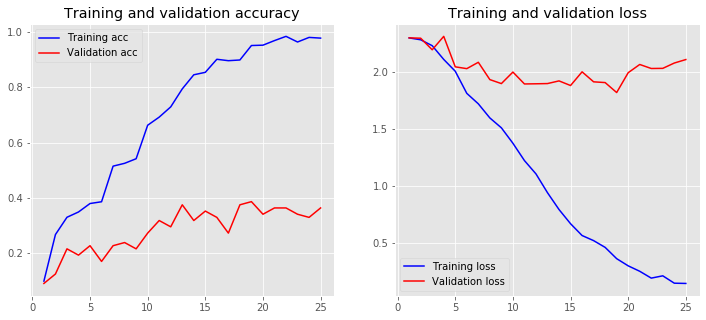

In [23]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
plot_history(history)